In [3]:
pip install spotipy

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import streamlit as st
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import metrics
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('Spotify_music.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  10000 non-null  object 
 1   track_name                9998 non-null   object 
 2   track_artist              9998 non-null   object 
 3   track_popularity          10000 non-null  int64  
 4   track_album_id            10000 non-null  object 
 5   track_album_name          9998 non-null   object 
 6   track_album_release_date  10000 non-null  object 
 7   playlist_name             10000 non-null  object 
 8   playlist_id               10000 non-null  object 
 9   playlist_genre            10000 non-null  object 
 10  playlist_subgenre         10000 non-null  object 
 11  danceability              10000 non-null  float64
 12  energy                    10000 non-null  float64
 13  key                       10000 non-null  int64  
 14  loudnes

In [6]:
dx = data.copy()

In [7]:
# Check for missing or null values and sort them
dx.isnull().sum()
dx.dropna(inplace = True)


In [8]:
dx.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000,9998.000000
mean,42.287157,0.653920,0.697638,5.424385,-6.769501,0.560312,0.107443,0.176562,0.087207,0.189342,0.510157,120.985622,225885.227746
std,24.853357,0.146814,0.182592,3.593314,3.025981,0.496374,0.101661,0.219232,0.227022,0.152285,0.235322,27.131441,60225.220264
min,0.000000,0.077100,0.000175,0.000000,-35.960000,0.000000,0.022800,0.000002,0.000000,0.009360,0.000010,38.985000,31893.000000
25%,24.000000,0.561000,0.577000,2.000000,-8.236750,0.000000,0.041400,0.014900,0.000000,0.092125,0.328000,99.427500,187117.500000
50%,45.000000,0.669000,0.722000,6.000000,-6.206000,1.000000,0.062900,0.080500,0.000018,0.127000,0.514000,121.993000,216044.000000
75%,62.000000,0.761000,0.841000,9.000000,-4.644250,1.000000,0.132000,0.259000,0.005965,0.249000,0.696000,133.990000,253733.000000
max,100.000000,0.981000,1.000000,11.000000,-0.155000,1.000000,0.877000,0.992000,0.987000,0.990000,0.981000,220.252000,517810.000000


In [9]:
# Check for duplicates and drop them
dx.duplicated().sum()

0

In [10]:
dx.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [11]:
dx.drop(columns=["track_id", "track_album_id", "playlist_id","playlist_subgenre", "track_album_release_date", "valence"],axis=1,inplace=True)
dx.drop(columns=["playlist_name", "energy", "key","loudness", "speechiness", "mode", ],axis=1,inplace=True)

In [12]:
dx.drop(["liveness", "danceability", "acousticness"], axis =1, inplace = True)

In [13]:
categoricals = dx.select_dtypes(include = ['object', 'category'])
numericals = dx.select_dtypes(include = 'number')
categoricals

,track_name,track_artist,track_album_name,playlist_genre
0,Clandestino (feat. Calypso Rose),Manu Chao,Clandestino (feat. Calypso Rose),latin
1,Gangland,Mankirt Aulakh,Mankirt Aulakh - Best Hits,rap
2,Dead 2 Me,Emily Vaughn,Dead 2 Me,pop
3,Talk - Alle Farben Remix,Khalid,Talk (Alle Farben Remix),latin
4,Rockstar on the Moon,Dr.ive,Rockstar on the Moon,rap
...,...,...,...,...
9995,Do Copo Eu Vim (feat. Marília Mendonça) - Ao V...,Diego & Victor Hugo,Do Copo Eu Vim (feat. Marília Mendonça) [Ao Vi...,edm
9996,Perreito - Remix,Mariah,Perreito (Remix),latin
9997,Like This,Sebastian Park,Like This,edm
9998,JOYFUL,X Ambassadors,JOYFUL,r&b


In [14]:
dx.drop('track_album_name', axis = 1, inplace = True)

In [15]:
dx

,track_name,track_artist,track_popularity,playlist_genre,instrumentalness,tempo,duration_ms
0,Clandestino (feat. Calypso Rose),Manu Chao,54,latin,0.000002,84.791,158715
1,Gangland,Mankirt Aulakh,46,rap,0.000000,86.452,168000
2,Dead 2 Me,Emily Vaughn,36,pop,0.000000,160.097,165000
3,Talk - Alle Farben Remix,Khalid,56,latin,0.000018,126.015,167990
4,Rockstar on the Moon,Dr.ive,32,rap,0.001570,89.989,167750
...,...,...,...,...,...,...,...
9995,Do Copo Eu Vim (feat. Marília Mendonça) - Ao V...,Diego & Victor Hugo,73,edm,0.000000,116.993,144071
9996,Perreito - Remix,Mariah,72,latin,0.000225,180.007,210360
9997,Like This,Sebastian Park,30,edm,0.875000,123.999,199355
9998,JOYFUL,X Ambassadors,46,r&b,0.000021,77.439,232560


In [16]:
dx['track_name'] = dx['track_name'].str.replace('-', ' ')

In [17]:
dx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9998 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        9998 non-null   object 
 1   track_artist      9998 non-null   object 
 2   track_popularity  9998 non-null   int64  
 3   playlist_genre    9998 non-null   object 
 4   instrumentalness  9998 non-null   float64
 5   tempo             9998 non-null   float64
 6   duration_ms       9998 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 624.9+ KB


In [39]:
dx['tags'] = dx['playlist_genre']+' '+dx['track_artist']
dx['tags'][0]

'latin Manu Chao'

In [41]:
df = dx[['track_name', 'tags', 'track_artist']]
df

,track_name,tags,track_artist
0,Clandestino (feat. Calypso Rose),latin Manu Chao,Manu Chao
1,Gangland,rap Mankirt Aulakh,Mankirt Aulakh
2,Dead 2 Me,pop Emily Vaughn,Emily Vaughn
3,Talk Alle Farben Remix,latin Khalid,Khalid
4,Rockstar on the Moon,rap Dr.ive,Dr.ive
...,...,...,...
9995,Do Copo Eu Vim (feat. Marília Mendonça) Ao V...,edm Diego & Victor Hugo,Diego & Victor Hugo
9996,Perreito Remix,latin Mariah,Mariah
9997,Like This,edm Sebastian Park,Sebastian Park
9998,JOYFUL,r&b X Ambassadors,X Ambassadors


In [42]:
df['tags'] = df['tags'].apply(lambda x:x.lower())
df 

,track_name,tags,track_artist
0,Clandestino (feat. Calypso Rose),latin manu chao,Manu Chao
1,Gangland,rap mankirt aulakh,Mankirt Aulakh
2,Dead 2 Me,pop emily vaughn,Emily Vaughn
3,Talk Alle Farben Remix,latin khalid,Khalid
4,Rockstar on the Moon,rap dr.ive,Dr.ive
...,...,...,...
9995,Do Copo Eu Vim (feat. Marília Mendonça) Ao V...,edm diego & victor hugo,Diego & Victor Hugo
9996,Perreito Remix,latin mariah,Mariah
9997,Like This,edm sebastian park,Sebastian Park
9998,JOYFUL,r&b x ambassadors,X Ambassadors


In [43]:
cv = CountVectorizer(max_features = 2000)

In [44]:
vectors = cv.fit_transform(df['tags']).toarray()

In [45]:
vectors.shape

(9998, 2000)

In [24]:
feature_names = cv.get_feature_names()

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [46]:
similar = cosine_similarity(vectors)

In [47]:
sorted(list(enumerate(similar[0])), reverse=True, key=lambda x: x[1])


[(0, 1.0),
 (18, 1.0),
 (42, 1.0),
 (45, 1.0),
 (70, 1.0),
 (102, 1.0),
 (123, 1.0),
 (164, 1.0),
 (188, 1.0),
 (189, 1.0),
 (234, 1.0),
 (254, 1.0),
 (272, 1.0),
 (278, 1.0),
 (331, 1.0),
 (358, 1.0),
 (360, 1.0),
 (379, 1.0),
 (397, 1.0),
 (516, 1.0),
 (520, 1.0),
 (545, 1.0),
 (550, 1.0),
 (552, 1.0),
 (562, 1.0),
 (620, 1.0),
 (625, 1.0),
 (635, 1.0),
 (647, 1.0),
 (648, 1.0),
 (654, 1.0),
 (691, 1.0),
 (764, 1.0),
 (770, 1.0),
 (782, 1.0),
 (798, 1.0),
 (821, 1.0),
 (864, 1.0),
 (879, 1.0),
 (885, 1.0),
 (892, 1.0),
 (946, 1.0),
 (959, 1.0),
 (996, 1.0),
 (1002, 1.0),
 (1077, 1.0),
 (1080, 1.0),
 (1154, 1.0),
 (1188, 1.0),
 (1207, 1.0),
 (1226, 1.0),
 (1232, 1.0),
 (1260, 1.0),
 (1321, 1.0),
 (1334, 1.0),
 (1350, 1.0),
 (1364, 1.0),
 (1371, 1.0),
 (1406, 1.0),
 (1430, 1.0),
 (1476, 1.0),
 (1488, 1.0),
 (1581, 1.0),
 (1604, 1.0),
 (1628, 1.0),
 (1640, 1.0),
 (1648, 1.0),
 (1771, 1.0),
 (1847, 1.0),
 (1857, 1.0),
 (1912, 1.0),
 (2048, 1.0),
 (2071, 1.0),
 (2080, 1.0),
 (2110, 1.0),


In [48]:
def recommender(songs):
    songs_index=df[df['track_name']==songs].index[0]
    distance = similar[songs_index]
    songs_list = sorted(list(enumerate(distance)), reverse = True, key = lambda x:x[1])[1:50]
    for i in songs_list:
        print(df.iloc[i[0]].track_name)

In [51]:
df.head()

,track_name,tags,track_artist
0,Clandestino (feat. Calypso Rose),latin manu chao,Manu Chao
1,Gangland,rap mankirt aulakh,Mankirt Aulakh
2,Dead 2 Me,pop emily vaughn,Emily Vaughn
3,Talk Alle Farben Remix,latin khalid,Khalid
4,Rockstar on the Moon,rap dr.ive,Dr.ive


In [53]:
recommender('Rockstar on the Moon')

Xxplosive
Nuthin' But A "G" Thang
Forgot About Dre
The Next Episode
Forgot About Dre
The Next Episode
Xxplosive
Gangland
Lacee's Groove
Triple Helix
Saké
PHANTOM
Racks In The Middle (feat. Roddy Ricch and Hit Boy)
Tomb (feat. Rasha Kamal)
Mile Away
Prefiero
Posted
Tonight's Da Night
Es rollt wieder
Supersonic
Labyrinth
Lowkey (feat. Lil Traffic)
Yesterday
Город под подошвой
Пламя
Fé Pros Real
Стволок за поясок
Thief
Mi Familia
Let's Straighten It Out
Co u Ciebie?
Envy Me
Independent (feat. Lil' Boosie and Lil' Phat)
Fondue
Assassina
Think for Yourself
Çöl
Função
Careless
Summertime
Io sono qui
LECI NOWY FUTURE
Sumô
Dopeman   Remix
Oblivion
Hortelã
Guava
За туманами
A Little Less Conversation (feat. The Great Escape)


In [28]:
# pickle.dump(df, open('music_recommend.pkl', 'wb'))
model = pickle.dump(df, open('df.pkl', 'wb'))

In [30]:
pickle.dump(similar, open('similar.pkl', 'wb'))

In [16]:
# columns_to_encode = ['track_name', 'track_artist', 'track_album_name', 'playlist_name', 'playlist_genre']
# chunk_size = 1000  # Define the chunk size for encoding
# start_idx = 0

# # Iterate over chunks
# while start_idx < len(sampledf):
#     end_idx = start_idx + chunk_size
#     if end_idx > len(sampledf):
#         end_idx = len(sampledf)

#     # Get a chunk of data
#     chunk = sampledf.iloc[start_idx:end_idx]

#     # Perform one-hot encoding for each column in the chunk
#     encoded_chunks = []
#     for col in columns_to_encode:
#         encoded_chunk = pd.get_dummies(chunk[col], prefix=col)
#         encoded_chunks.append(encoded_chunk)

# # Merge the encoded chunks back into the original DataFrame
# encoded_df = pd.concat(encoded_chunks, axis=1)
# sampledf = pd.concat([sampledf, encoded_df], axis=1)


# # Drop the original categorical columns after encoding
# sampledf.drop(columns_to_encode, axis=1, inplace=True)

# print(sampledf.head())


In [17]:
encoded_df = pd.get_dummies(sampledf, columns=['track_name', 'track_artist', 'track_album_name', 'playlist_name', 'playlist_genre'])
encoded_df

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,playlist_name_🔊BASSBOOSTED🔊⚡ELECTRO HOUSE⚡🔥EDM CAR MUSIC2018/2019🔥,"playlist_name_🔥💵 Hip Hop, Rap, Heavy 808's - New School",playlist_name_🔥🦁 GOOD VIBES ONLY 🦁🔥 // BROEDERLIEFDE || FRENNA || BROEDERS || HENKIE T || BIZZEY || POKE \\,playlist_name_🤩🤪Post Teen Pop🤪🤩,playlist_genre_edm,playlist_genre_latin,playlist_genre_pop,playlist_genre_r&b,playlist_genre_rap,playlist_genre_rock
19398,15,0.771,0.574,6,-11.093,0,0.0620,0.104000,0.000641,0.1070,...,0,0,0,0,0,1,0,0,0,0
15734,33,0.524,0.970,7,-4.815,1,0.2780,0.000026,0.000000,0.0796,...,0,0,0,0,0,0,0,0,0,1
23502,36,0.570,0.419,10,-8.440,1,0.0330,0.766000,0.000009,0.0853,...,0,0,0,0,0,0,0,1,0,0
22075,59,0.389,0.665,0,-6.169,1,0.0644,0.178000,0.000732,0.1160,...,0,0,0,0,0,0,0,1,0,0
16061,1,0.662,0.763,0,-7.475,1,0.0397,0.132000,0.001300,0.0670,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,2,0.389,0.915,6,-3.261,1,0.0456,0.000752,0.013300,0.1220,...,0,0,0,0,0,0,1,0,0,0
28349,53,0.779,0.948,5,-4.296,0,0.0943,0.036700,0.643000,0.2950,...,0,0,0,0,1,0,0,0,0,0
10955,38,0.369,0.776,9,-6.068,0,0.1150,0.005870,0.000021,0.0974,...,0,0,0,0,0,0,0,0,1,0
11095,80,0.903,0.675,11,-3.445,0,0.2140,0.542000,0.000013,0.0595,...,0,0,0,0,0,0,0,0,1,0


In [18]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming categorical_columns is a list of the categorical column names after label encoding
encoder = LabelEncoder()

# Convert label-encoded categorical columns to numeric types
for col in categoricals:
    sampledf[col] = encoder.fit_transform(sampledf[col])

# Separate numeric columns for scaling
numeric_columns = sampledf.select_dtypes(include=np.number).columns.tolist()


In [19]:
# Scaling the dataframe
scaled_data = scalar.fit_transform(sampledf)

In [20]:
# Converting dataframe into 2D for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components ,columns=["PCA1","PCA2"])
pca_df

,PCA1,PCA2
0,1.037292,-0.755810
1,-0.827846,0.150557
2,2.823769,0.215951
3,0.582388,1.960345
4,-0.025404,-0.032265
...,...,...
9995,-1.899372,1.939598
9996,-2.099669,0.748513
9997,-0.620234,1.358498
9998,1.096848,-1.367522


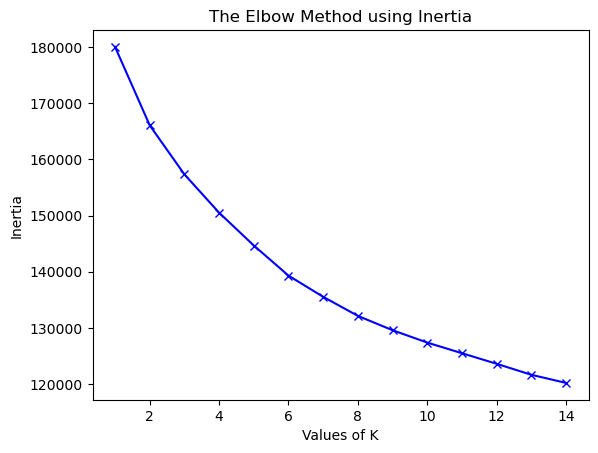

In [21]:
inertia = []
range_val = range(1,15)
for i in range_val:
    kmean = KMeans(n_clusters=i)
    kmean.fit_predict(pd.DataFrame(scaled_data))
    inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [22]:
# Using Kmeans to create our model for clustering
kmeans_model=KMeans(6)
kmeans_model.fit_predict(scaled_data)
pca_newdata_kmeans= pd.concat([pca_df,pd.DataFrame({'cluster':kmeans_model.labels_})],axis=1)

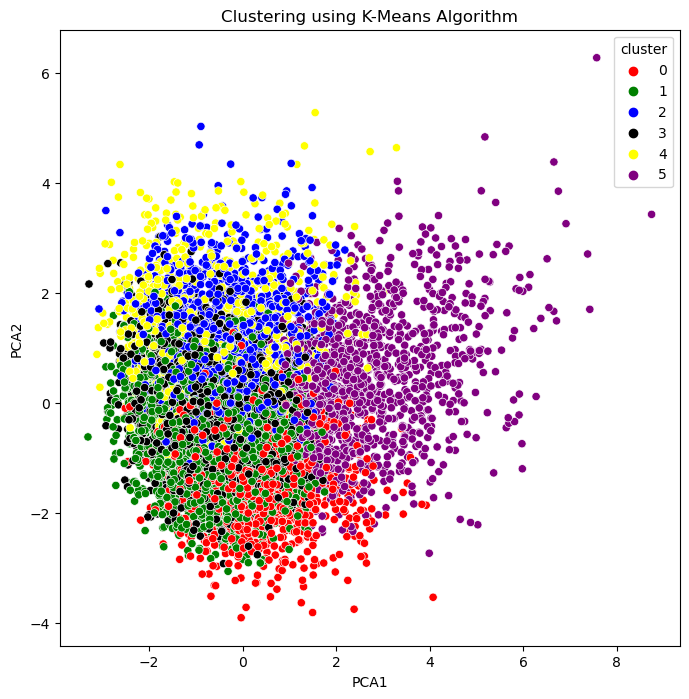

In [23]:
plt.figure(figsize=(8,8))
ax=sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_newdata_kmeans,palette=['red','green','blue','black','yellow','purple'])
plt.title("Clustering using K-Means Algorithm")
plt.show()

In [24]:
# find all cluster centers
cluster_centers = pd.DataFrame(data=kmeans_model.cluster_centers_,columns=[sampledf.columns])
# inverse transform the data
cluster_centers = scalar.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers,columns=[sampledf.columns])
cluster_centers

,track_name,track_artist,track_popularity,track_album_name,playlist_name,playlist_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,4300.045291,2391.084112,43.226456,3857.273185,223.810927,3.248023,0.735045,0.658005,5.757728,-6.947093,0.455787,0.301815,0.177983,0.011186,0.199744,0.558700,117.973786,220695.579439
1,2340.991446,2304.252546,43.155193,2061.842363,214.942974,1.680244,0.695247,0.749807,4.983299,-5.643889,0.563340,0.077777,0.122320,0.017141,0.180853,0.550183,117.474967,218905.039104
2,4403.309259,2860.709259,40.278395,3957.399383,235.922222,4.197531,0.493496,0.778583,5.161111,-6.324614,0.690741,0.071250,0.074022,0.029263,0.231527,0.470617,135.908669,249699.525926
3,6215.875515,2531.147568,45.659110,5724.228359,208.411377,1.606760,0.694021,0.744298,5.843364,-5.625255,0.503710,0.076337,0.121557,0.017804,0.189781,0.548089,118.035303,213858.591509
4,4302.528628,2517.428762,27.299601,3992.901465,206.482024,1.027963,0.672033,0.794048,5.459387,-6.795365,0.555260,0.071250,0.067107,0.734908,0.199400,0.379454,125.731895,255193.874834
5,4462.375092,2388.786293,44.459101,3732.579956,251.529108,3.106853,0.610608,0.429344,5.066323,-10.633151,0.597642,0.071100,0.520785,0.112186,0.154572,0.420244,114.371153,222349.708917


In [25]:
# Creating a target column "Cluster" for storing the cluster segment
# cluster_df = pd.concat([df,pd.DataFrame({'Cluster':kmeans_model.labels_})],axis=1)
cluster_df

NameError: name 'cluster_df' is not defined

In [ ]:
tfidvector = TfidfVectorizer(analyzer='word',stop_words='english')
matrix = tfidvector.fit_transform(sampledf['track_name'])
similarity = cosine_similarity(matrix)